In [1]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
from ROOT import gROOT,gStyle,gPad
from ROOT import std
import csv
import json
from array import array
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

import numpy as np
import importlib

import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
import CrystalMap as crystMap
from uncertainties import unumpy
from uncertainties import ufloat
import pandas as pd

Welcome to JupyROOT 6.18/00


In [2]:
outstr = 'timeuniformity_C3_MCP2_flipped'
#trees_path = '/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/'
trees_path = '/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7/'

dir_str = '/13_09_2019/'
plot_folder = 'plots/'+dir_str
output_folder = 'output/'+dir_str
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
dict_C3_energy_scan = {}
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C_and3x3.csv', 'r'))
#reader = csv.reader(open('data/energyscans19C_3x3.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if ('C3' in crystal) or ('C2' in crystal) or ('C4' in crystal):
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        

            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
dict_crystal_centers['C3_3x3'] =[4,5]       
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')        
matrix_3_C4 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3'.split(',')        
matrix_3_C2 = 'B3,C3,D3,B2,C2,D2,B1,C1,D1'.split(',')        


energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]
round_energies = [round(float(energy),-1) for energy in energies]
if round_energies[-1] ==240 : round_energies[-1] = 250.

In [4]:
dict_df_energy = {}

for energy in energies:
#for energy in [energies[-1]]:
    
    runs = dict_C3_energy_scan[energy]
    tree = ROOT.TChain("h4")
    for run in runs:
        tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
    pos_cut = 4
    data = []
    for evt in tree:
        ############CHange e3x3 cut per energy!!!!!########
       # if evt.n_tracks==1 and evt.e3x3<10000. and evt.e3x3>8300. and evt.X[0] > -9. and evt.X[0] < 1. and evt.Y[0]>-1. and evt.Y[0]<8. : 
        if evt.n_tracks==1 and evt.X[0] > -9. and evt.X[0] < 1. and evt.Y[0]>-1. and evt.Y[0]<8. : 

            evt_dict = {}
            e = round(float(evt.Energy),-1)
            if e ==240 : e = 250.
            evt_dict['Energy'] = e
            evt_dict['run'] = run
            evt_dict['e3x3'] = evt.e3x3
            evt_dict['seed'] = evt.seed
            evt_dict['fit_ampl_MCP1'] = evt.fit_ampl[evt.MCP1]/evt.b_rms[evt.MCP1]
            evt_dict['fit_ampl_MCP2'] = evt.fit_ampl[evt.MCP2]/evt.b_rms[evt.MCP2]
            evt_dict['fit_time_MCP1'] = evt.fit_time[evt.MCP1]
            evt_dict['fit_time_MCP2'] = evt.fit_time[evt.MCP2]
            evt_dict['fit_time_VFE_CLK'] = evt.fit_time[evt.VFE_CLK]            
            for xstal in working:
                evt_dict['fit_ampl_'+xstal] = evt.fit_ampl[getattr(evt, xstal)]
                evt_dict['amp_max_'+xstal] = evt.amp_max[getattr(evt, xstal)]
                evt_dict['noise_'+xstal] = evt.b_rms[getattr(evt, xstal)]
                evt_dict['fit_time_'+xstal] = evt.fit_time[getattr(evt, xstal)]
                evt_dict['fit_terr_'+xstal] = evt.fit_terr[getattr(evt, xstal)]
                evt_dict['%s'%xstal] = getattr(evt,xstal)
            data.append(evt_dict)

    df = pd.DataFrame(data) 
    dict_df_energy[energy] = df

    pd_name = '%s/ECAL_H4_October2018_pandas_C3beamscan_full5_%s.csv'%(trees_path,int(e))
   # pd_name = '%s/ECAL_H4_October2018_pandas_C3_3x3_%s.csv'%(trees_path,int(e))
    df.to_csv(pd_name)

KeyboardInterrupt: 

Warning in <TClass::Init>: no dictionary for class PositionMeasurement is available
Warning in <TClass::Init>: no dictionary for class TrackPar is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayer is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayout is available
Warning in <TClass::Init>: no dictionary for class CfgManager is available


In [4]:
### Only used when I dont want to rerun the dataframe creation (takes longer than read csv file)
dict_df_energy = {}
for energy in round_energies:
#for energy in energies:
    pd_name = '%s/ECAL_H4_October2018_pandas_C3beamscan_full5_%s.csv'%(trees_path,int(energy))
    print(pd_name)
    df = pd.read_csv(pd_name)    
    dict_df_energy[energy] = df

/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full5_50.csv
/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full5_100.csv
/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full5_150.csv
/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full5_200.csv
/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full5_250.csv


In [5]:
## Remove all 3x3 data    
runs_to_remove =[]
reader = csv.reader(open('data/energyscans19C_3x3.csv', 'r'))
for row in reader:
    run,e,c,_,_,_ = row
    if ('Run'  not in run) :
        runs_to_remove.append(run)
        
for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    for run in runs_to_remove:
        df.drop(df[df.run == run].index, inplace=True)
        dict_df_energy[int(energy)]  = df
        

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


<Figure size 432x288 with 0 Axes>

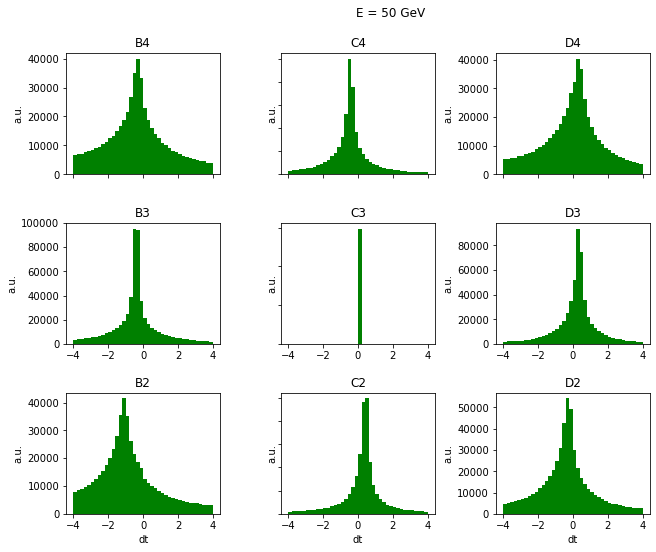

<Figure size 432x288 with 0 Axes>

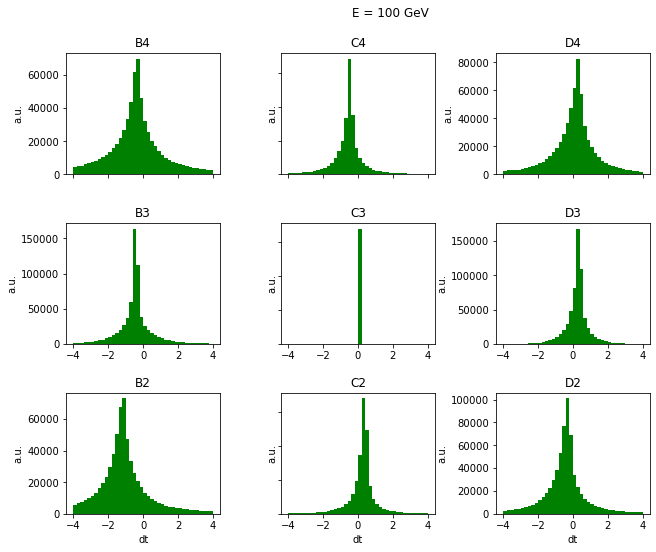

<Figure size 432x288 with 0 Axes>

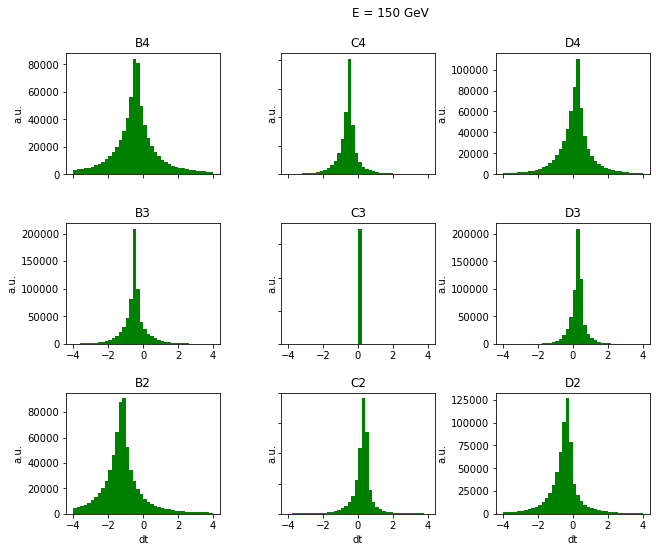

<Figure size 432x288 with 0 Axes>

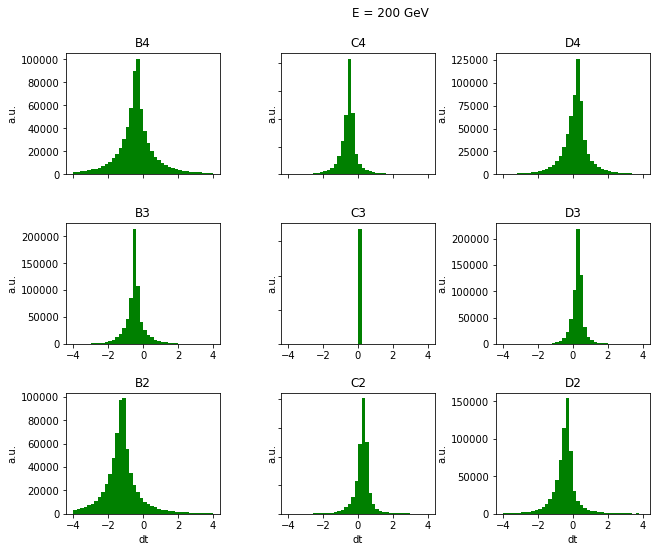

<Figure size 432x288 with 0 Axes>

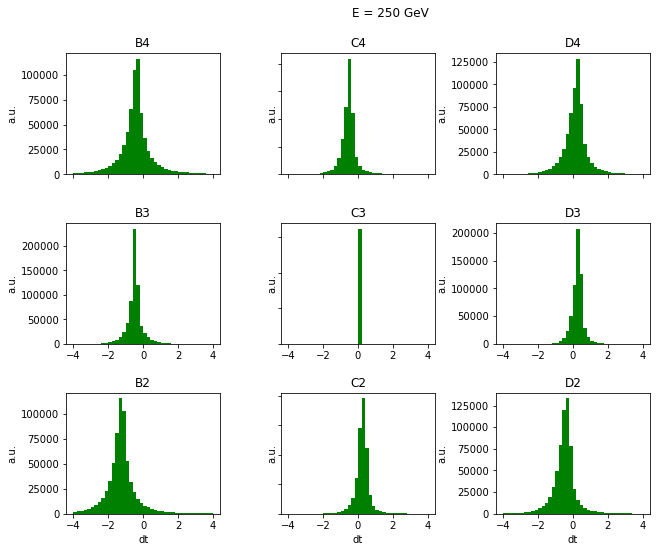

In [6]:
for num,energy in enumerate(energies):
    df = dict_df_energy[round_energies[num]] 
    plt.clf()
    f, axarr = plt.subplots(3, 3)
    f.suptitle('E = %d GeV'%round_energies[num])
    DefaultSize = f.get_size_inches()
    f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
    for i in range(0,3):
        for j in range(0,3):
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
            m = np.array(matrix_3).reshape(3,3)
            crystal = m[i,j]
            dt = df['fit_time_C3']-df['fit_time_%s'%crystal]
            dt = dt-(dt/6.25).astype('int32')*6.25
            axarr[i, j].hist(list(dt),range=[-4,4],bins=40,color='g')
            axarr[i, j].set_title(crystal)
            if i==2 : axarr[i, j].set_xlabel('dt')
            axarr[i, j].set_ylabel('a.u.')
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
    f.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    figname = '%s/dt_C3_crystal_%d_%s'%(plot_folder,round_energies[num],outstr)
    f.savefig(figname+'.png')
    f.savefig(figname+'.pdf')

## Per each event we want to calculate x and y of where the electron beam had it's impact

In [7]:
#crystal = 'C3'
#conditions = [
#    (df['fit_ampl_%s'%crystal] > 0 ),
#    (df['fit_ampl_%s'%crystal] <= 0)]
#choices = [df['fit_ampl_%s'%crystal], df['amp_max_%s'%crystal]]
#df['final_ampl_%s'%crystal] = np.select(conditions, choices)      
        

In [7]:
from math import log

intercalibration_file = '/eos/user/n/nchernya/SWAN_projects/ECALtestBeam/output/01_08_2019_v7/conversion_factor_v7.json'
with open('%s'%(intercalibration_file), 'r') as fp:
    dict_crystals_calibration = json.load(fp)

for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    for cr in 'C2,C3,C4'.split(','):
        df['sum_3x3_%s'%cr]=0.
        if cr=='C3' :
            for crystal in matrix_3:
                df['sum_3x3_%s'%cr] += df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]
        elif cr=='C2' : 
            for crystal in matrix_3_C2:
                df['sum_3x3_%s'%cr] += df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]
        elif cr=='C4' : 
            for crystal in matrix_3_C4:
                df['sum_3x3_%s'%cr] += df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]

In [8]:
## loose selection
#energy_selection = [[1500,2000],[2500,4000],[4000,5900],[5000,7900],[7000,9800]]
energy_selection = [[500,2000],[500,4000],[500,5900],[500,7900],[500,9800]]
for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    df = df.loc[(df['sum_3x3_C3']<energy_selection[num][1]) & (df['sum_3x3_C3']>energy_selection[num][0])]
    df = df.loc[(df['fit_ampl_MCP2']>100)]
    dict_df_energy[int(energy)] = df
    
#ranges = [[1500,2500],[2000,4500],[4000,6500],[5000,9000],[7000,10000]]
#for n,energy in enumerate(energies):
#    df = dict_df_energy[energy]
#    plt.yscale('log')
#    _,_,_ = plt.hist(df['sum_3x3'],bins=100,range=ranges[n])
#    plt.show()

In [9]:
matrix_used = matrix_3

for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    
    for cr in 'C2,C3,C4'.split(','):
        df['pos_sum_w_%s'%cr]=0.
        df['ecal_x_%s'%cr]=0.
        df['ecal_y_%s'%cr]=0.
        
        if cr=='C3' : matrix_used = matrix_3
        elif cr=='C2' :  matrix_used = matrix_3_C2
        elif cr=='C4' :  matrix_used = matrix_3_C4
            
        for i in range(0,3):
            for j in range(0,3):
                m = np.array(matrix_used).reshape(3,3)
                crystal = m[i,j]    
                w = 4.2 +  np.log(df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]/df['sum_3x3_%s'%cr])
                w[w < 0] = 0
                df['ecal_x_%s'%cr] += ((j+1)*22-11-33)*w  # x and y are counted from C3 center (-33)
                df['ecal_y_%s'%cr] += ((i+1)*22-11-33)*w  # x and y are counted from C3 center (-33)
                df['pos_sum_w_%s'%cr] += w
    
        df['ecal_x_%s'%cr]/=df['pos_sum_w_%s'%cr]
        df['ecal_y_%s'%cr]/=df['pos_sum_w_%s'%cr]
        df['ecal_r_%s'%cr] = np.sqrt(df['ecal_x_%s'%cr]*df['ecal_x_%s'%cr] + df['ecal_y_%s'%cr]*df['ecal_y_%s'%cr])
    dict_df_energy[int(energy)] = df


/usr/local/bin/start_ipykernel.py:19: RuntimeWarning: divide by zero encountered in log
/usr/local/bin/start_ipykernel.py:19: RuntimeWarning: invalid value encountered in log


In [10]:
time_intercalib_file = '/eos/user/n/nchernya/SWAN_projects/ECALtestBeam/output/13_09_2019_timeintercalibration/time_intercalibration_result_itnercal.json'   
with open('%s'%(time_intercalib_file), 'r') as fp:
    dict_crystals_timecalibration = json.load(fp)

for k,df in dict_df_energy.items():
    for i in range(0,3):
        for j in range(0,3):
            crystal = m[i,j]
            if 'C3' in crystal : continue
                
            df['dt_ecal_MCP_%s_calib'%crystal] = df['fit_time_%s'%crystal] + dict_crystals_timecalibration['%s'%crystal] - df['fit_time_MCP2'] + df['fit_time_VFE_CLK']
            df['dt_ecal_MCP_%s_calib'%crystal] = df['dt_ecal_MCP_%s_calib'%crystal] - ((df['dt_ecal_MCP_%s_calib'%crystal]/6.238).astype('int32')*6.238)

/usr/local/bin/start_ipykernel.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyError: 'dt_ecal_MCP_B2_calib'

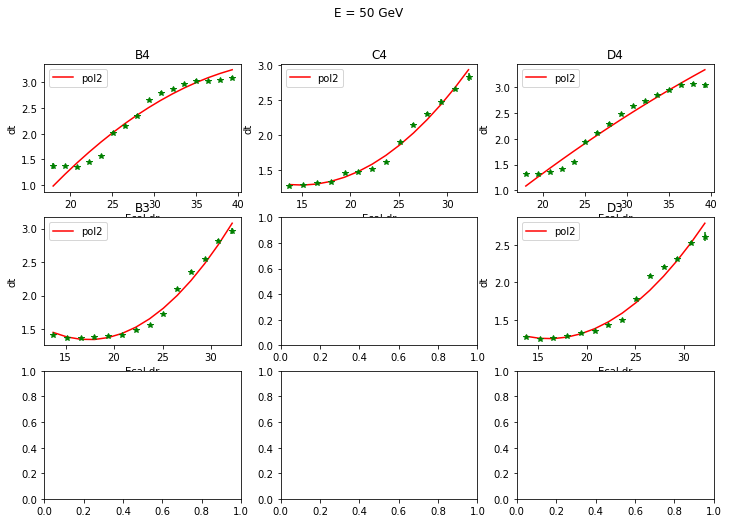

In [11]:
import seaborn as sns
from scipy.stats import crystalball
from math import sqrt, isnan
from scipy import optimize

def pol3(x, p1, p2, p3,p4):
    return p1 + p2*x + p3*x*x + p4*x*x*x

def parabola(x, p1, p2, p3):
    return p1 + p2*x + p3*x*x

def parabola_fixed(x, p1, p3):
    return p1 + p3*x*x

def parabola_fixed_border(x, p1, p3,border=11):
    return p1 + p3*(x-border)*(x-border)

dict_dt_fit = {}
dict_dt_fit_3param = {}

what_to_plot = ['dt','res']
what_idx = 0

m = np.array(matrix_3).reshape(3,3)

#for num,energy in enumerate(round_energies[3:5]):
for num,energy in enumerate(round_energies):

    df = dict_df_energy[int(energy)]

    dict_dt_fit[int(energy)] = {}
    dict_dt_fit_3param[int(energy)] = {}

    f, axarr = plt.subplots(3, 3)
    DefaultSize = f.get_size_inches()
    f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
    f.suptitle('E = %d GeV'%energy)
    
    # dr_samples = np.linspace(0, 20.0, num=10)
    #dr_samples = [0,2,3,4,5,6,7,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,14,15,16,17,18]
  #  dr_samples = [0,2,3,4,5,6,7,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,14,15]   
  #  dr_samples = np.linspace(0, 12.0, num=12)   
    
    dr_samples = np.linspace(13, 40.0, num=20)  
    crystals_times_data = []
    crystals_dr_data = []

    subdf = df.loc[(df['seed']==df['C3']) & (abs(df['ecal_x_C3'])<9) & (abs(df['ecal_y_C3'])<9)]
    for i in range(0,3):
        for j in range(0,3):
                           
            crystal = m[i, j]
            if crystal == 'C3': continue                

            x_center = (j+1)*22.-11-33
            y_center = (i+1)*22.-11-33
      
            subdf['dr_%s'%crystal] = np.sqrt(np.power(subdf['ecal_x_C3']-x_center,2) + np.power(subdf['ecal_y_C3']-y_center,2))

            delta_ts_cb_mean = []
            delta_ts_cb_mean_err = []
            delta_ts_cb_std = []
            delta_ts_cb_std_err = []
            dr_samples_bins = []        
            
            for num_dr in range(0,len(dr_samples)-1):                
                subdf_r = subdf.loc[(subdf['dr_%s'%crystal]<dr_samples[num_dr+1]) & (subdf['dr_%s'%crystal]>dr_samples[num_dr])]
                subdf_r = subdf_r.loc[(subdf_r['dt_ecal_MCP_%s_calib'%crystal]<10) & (subdf_r['dt_ecal_MCP_%s_calib'%crystal]>-10)]   #2 - 3 for mcp1, 0.3-2 for mcp2
                subdf_r = subdf_r.loc[np.abs(subdf_r['dt_ecal_MCP_%s_calib'%crystal]-subdf_r['dt_ecal_MCP_%s_calib'%crystal].median())<3*subdf_r['dt_ecal_MCP_%s_calib'%crystal].std()]               
                serie = subdf_r['dt_ecal_MCP_%s_calib'%crystal] 

                #  if crystal=='C3' or (serie.shape[0]<100):
                if (serie.shape[0]<100):
                    loc = serie.median()
                    scale = serie.std()
                    if serie.shape[0]!=0 : 
                        time_err = serie.std()/sqrt(serie.shape[0])
                    else : time_err=0.02 
                else :  
                    beta, cb_m, loc, scale = crystalball.fit(serie,loc=serie.median(),scale=serie.std())
                    time_err = serie.std()/sqrt(serie.shape[0])
                if not isnan(loc):
                    dr_samples_bins.append(dr_samples[num_dr]+(dr_samples[num_dr+1]-dr_samples[num_dr])/2.)
                    delta_ts_cb_mean_err.append(time_err)
                    delta_ts_cb_mean.append(loc)
                    delta_ts_cb_std.append(scale) 
              
                
            if what_to_plot[what_idx] == 'dt' :
                #dr_cut = 15
                dr_cut = 100

                axarr[i, j].errorbar(dr_samples_bins, delta_ts_cb_mean, yerr=delta_ts_cb_mean_err, marker='*', linestyle='',color='g')
                params, params_covariance = optimize.curve_fit(parabola, np.array(dr_samples_bins)[np.array(dr_samples_bins)<dr_cut], np.array(delta_ts_cb_mean)[np.array(dr_samples_bins)<dr_cut],absolute_sigma=True, sigma=np.array(delta_ts_cb_mean_err)[np.array(dr_samples_bins)<dr_cut])
                axarr[i, j].plot(dr_samples_bins, parabola(np.array(dr_samples_bins), params[0], params[1],params[2]),color='r',label = 'pol2') #'p0=%.5f,\np1=%.5f,\np2=%.5f'%(params[0], params[1],params[2]))
                crystals_dr_data.append(dr_samples_bins)
                crystals_times_data.append([parabola(item, params[0], params[1],params[2]) for item in dr_samples_bins])

            else : axarr[i, j].plot(dr_samples_bins, delta_ts_cb_std, marker='*', linestyle='',color='g')


            axarr[i, j].set_title(crystal)
            axarr[i, j].set_xlabel('Ecal dr')
            if what_to_plot[what_idx] == 'dt' : axarr[i, j].set_ylabel('dt')
            else : axarr[i, j].set_ylabel('time resolution')
            axarr[i, j].legend(loc='upper left')
            
    axarr[1, 1].set_title('All Crystals') 
    for icry in range(0, len(crystals_dr_data)):
        out = axarr[1, 1].plot(crystals_dr_data[icry], crystals_times_data[icry])
    #axarr[1, 1].legend(iter(out),np.array(['C4','C2']),loc='upper left')

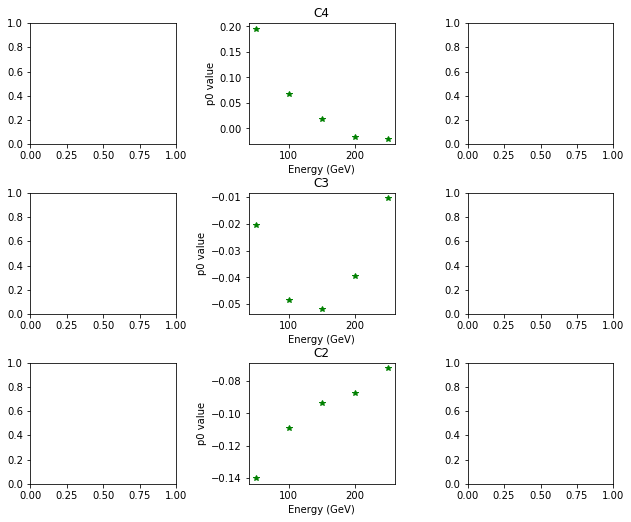

In [63]:
f, axarr = plt.subplots(3, 3)
DefaultSize = f.get_size_inches()
f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
    
for i in range(0,3):
    for j in range(0,3):
        
        if j!=1 : continue

        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        m = np.array(matrix_3).reshape(3,3)
        crystal = m[i,j]
        
        #if crystal!='C3': 
        if crystal!='AAAAA': 
            axarr[i, j].plot(round_energies,map(lambda x: dict_dt_fit[x][crystal]['parabola']['p1'],  round_energies) , marker='*', linestyle='',color='g')
       # axarr[i, j].set_ylim([0.00001,0.0015]) 
        axarr[i, j].set_title(crystal)
        axarr[i, j].set_ylabel('p0 value')
        axarr[i, j].set_xlabel('Energy (GeV)')
        #axarr[i, j].legend(loc='upper left')

f.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()
figname = '%s/dt_r_fitparams_p2_crystal_energy%d_%s'%(plot_folder,energy,outstr)
f.savefig(figname+'.png')
f.savefig(figname+'.pdf')

# Time intercalibration

In [67]:
for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    energy_sub=energy
    norm = parabola(dr_samples_bins[0], dict_dt_fit[energy_sub]['C4']['parabola']['p0'],dict_dt_fit[energy_sub]['C4']['parabola']['p1'],dict_dt_fit[energy_sub]['C4']['parabola']['p2'])
    
    for i in range(0,3):
        for j in range(0,3):
            crystal = m[i,j]
            if 'C3' in crystal : continue
            
            x_pos = (j+1)*22-11-33
            y_pos = (i+1)*22-11-33
            
            if j!=1:
                dt =  df['fit_time_%s'%crystal]-df['fit_time_MCP2']+df['fit_time_VFE_CLK']
                df['dt_ecal_MCP_%s'%crystal] = dt - ((dt/6.238).astype('int32')*6.238)
                
            df['dr_%s'%crystal] = np.sqrt(np.power(df['ecal_x_C3'] - x_pos,2) + np.power(df['ecal_y_C3'] - y_pos,2)) 
            subtract =  (parabola(np.array(df['dr_%s'%crystal]), dict_dt_fit[energy_sub]['C4']['parabola']['p0'],dict_dt_fit[energy_sub]['C4']['parabola']['p1'],dict_dt_fit[energy_sub]['C4']['parabola']['p2'])-norm)
            df['dt_ecal_MCP_%s_calib_subtracted'%crystal] = df['dt_ecal_MCP_%s_calib'%crystal] -subtract

In [68]:
def time_res_crystal(x, n= 1.07332e+04  ,c = 20.):
    return np.sqrt(n*n/(x*x) + c*c)


dict_df_energy_seedC3 = {}     
#for num,energy in enumerate(round_energies[3:5]):
for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    df = df[(df['seed']==df['C3'])]
    df['sum_time_crystals']=0.
    df['sum_inv_res']=0.
    for crystal in [c for c in filter(lambda c : c!='C3', matrix_3) ]:
        resolution = time_res_crystal((df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]/5.).values)
        df['sum_inv_res']+=1./resolution/resolution
      #  df['sum_inv_res']+=1
        df['sum_time_crystals'] += df['dt_ecal_MCP_%s_calib_subtracted'%crystal]/resolution/resolution
        #print(resolution)
        
    for crystal in ['C3']:
        resolution = time_res_crystal((df['fit_ampl_%s'%crystal]/df['noise_%s'%crystal]).values)
        df['sum_inv_res']+=1./resolution/resolution
      #  df['sum_inv_res']+=1
        df['sum_time_crystals'] += df['dt_ecal_MCP_%s'%crystal]/resolution/resolution
        #print(resolution)
        
    df['sum_time_crystals']/=df['sum_inv_res']
    
    dict_df_energy_seedC3[int(energy)] = df

/usr/local/bin/start_ipykernel.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:2: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/usr/local/bin/start_ipykernel.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

(50.0, 'dt_ecal_MCP_C3', 0.058381593912056766, 0.06078000241412688)
(50.0, 'sum_time_crystals', 0.05331478317674014, 0.05615057442541832)


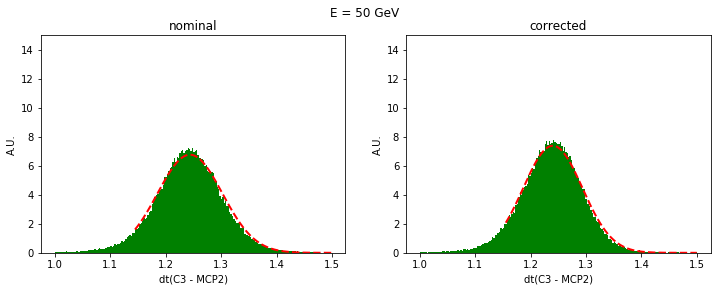

(100.0, 'dt_ecal_MCP_C3', 0.05165472776948785, 0.05165495204615917)
(100.0, 'sum_time_crystals', 0.04436846017138914, 0.04632441098882737)


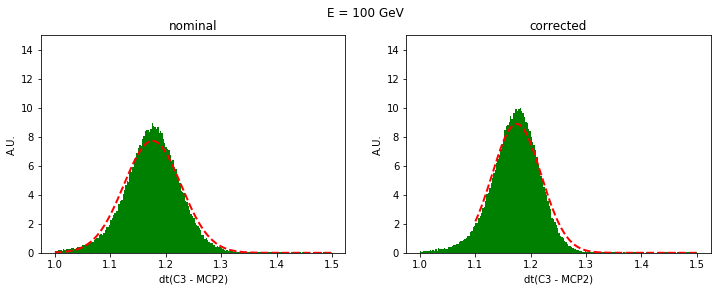

(150.0, 'dt_ecal_MCP_C3', 0.04678808905957016, 0.04678827171878151)
(150.0, 'sum_time_crystals', 0.04268741778030874, 0.043406736221495525)


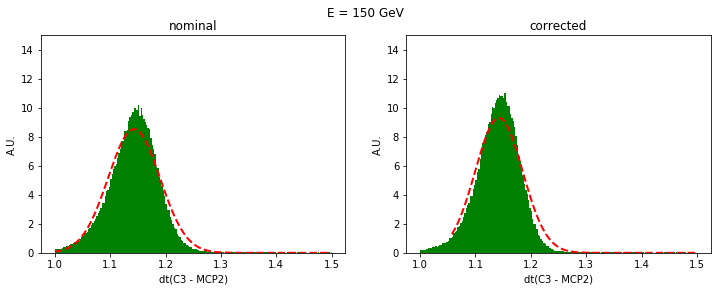

(200.0, 'dt_ecal_MCP_C3', 0.04542646659895413, 0.046453504454970665)
(200.0, 'sum_time_crystals', 0.0381437957245923, 0.040520184100189045)


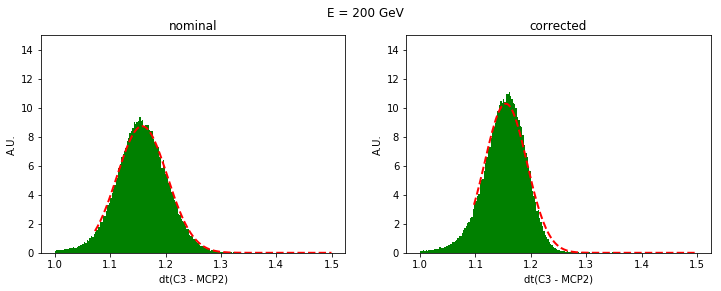

(250.0, 'dt_ecal_MCP_C3', 0.04669744394390881, 0.04789584185938679)
(250.0, 'sum_time_crystals', 0.0360074171588574, 0.03924713855548572)


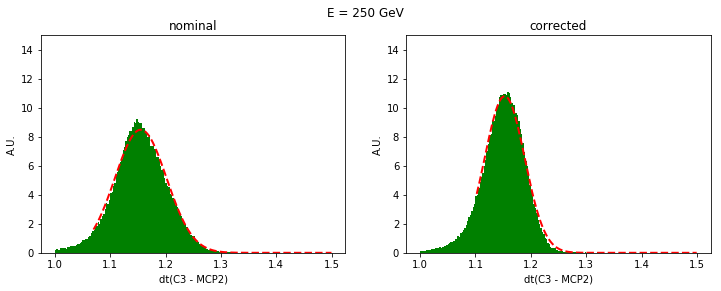

In [69]:
import matplotlib.mlab as mlab
from scipy.stats import norm

energy_selection = [[1500,2000],[2500,4000],[4000,5900],[5000,7900],[7000,9800]]

for n_energy,energy in enumerate(round_energies):
    df = dict_df_energy_seedC3[int(energy)]
    
    f, axarr = plt.subplots(1, 2)
    DefaultSize = f.get_size_inches()
    f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]) )
    f.suptitle('E = %d GeV'%energy)

    for num,what in enumerate('dt_ecal_MCP_C3,sum_time_crystals'.split(',')):
        legend = ['nominal','corrected']
        subdf = df.loc[(df['%s'%what]<1.5) & (df['%s'%what]>1) &  (df['seed'] == df['C3'])] 
     #   subdf = df
       # subdf = subdf.loc[(subdf['sum_3x3_C3']<energy_selection[n_energy][1]) & (subdf['sum_3x3_C3']>energy_selection[n_energy][0])]

        #subdf = df.loc[(np.abs(df['%s'%what]-df['%s'%what].median())<0.4)]
        # loc = subdf['%s'%what].median()
       # std = subdf['%s'%what].std()
       # subdf = df.loc[(np.abs(df['%s'%what]-loc)<5*std)]

        n,bins,_ = axarr[num].hist(subdf['%s'%what],bins=200,density=1,color='g')
        beta, cb_m, loc, scale = crystalball.fit(subdf['%s'%what],loc=loc,scale=0.03)
        y = crystalball.pdf( bins, beta, cb_m, loc, scale)
        #(mu, sigma) = norm.fit(subdf['%s'%what],loc=loc,scale=scale)
        #y = mlab.normpdf( bins, mu, sigma)
        l = axarr[num].plot(bins, y, 'r--', linewidth=2)
        axarr[num].set_title(legend[num])
        axarr[num].set_xlabel('dt(C3 - MCP2)')
        axarr[num].set_ylim(0,15) 
        axarr[num].set_ylabel('A.U.')
        
        print(energy, what, scale, subdf['%s'%what].std())
    plt.show()

(50.0, 'dt_ecal_MCP_D3', 'results : mu = 1.153, s = 0.037')
(50.0, 'dt_ecal_MCP_D3_calib', 'results : mu = 1.153, s = 0.037')
(50.0, 'dt_ecal_MCP_D3_calib_subtracted', 'results : mu = 1.153, s = 0.037')


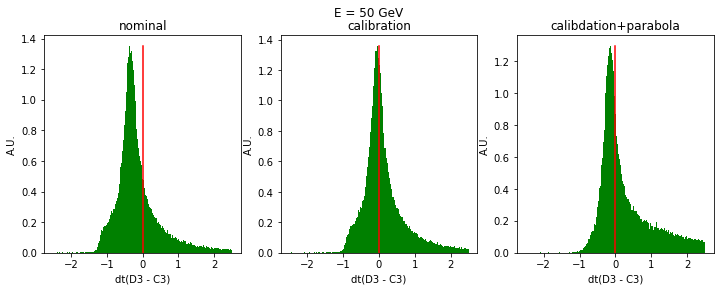

(100.0, 'dt_ecal_MCP_D3', 'results : mu = 1.153, s = 0.037')
(100.0, 'dt_ecal_MCP_D3_calib', 'results : mu = 1.153, s = 0.037')
(100.0, 'dt_ecal_MCP_D3_calib_subtracted', 'results : mu = 1.153, s = 0.037')


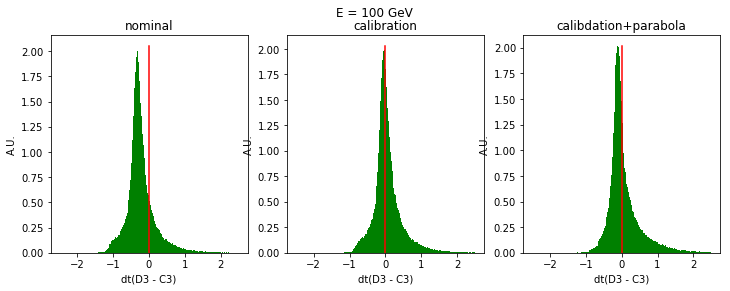

(150.0, 'dt_ecal_MCP_D3', 'results : mu = 1.153, s = 0.037')
(150.0, 'dt_ecal_MCP_D3_calib', 'results : mu = 1.153, s = 0.037')
(150.0, 'dt_ecal_MCP_D3_calib_subtracted', 'results : mu = 1.153, s = 0.037')


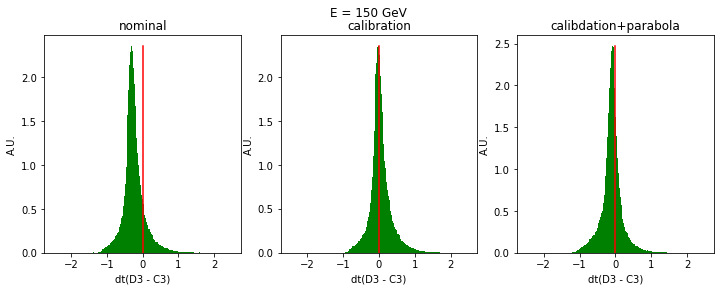

(200.0, 'dt_ecal_MCP_D3', 'results : mu = 1.153, s = 0.037')
(200.0, 'dt_ecal_MCP_D3_calib', 'results : mu = 1.153, s = 0.037')
(200.0, 'dt_ecal_MCP_D3_calib_subtracted', 'results : mu = 1.153, s = 0.037')


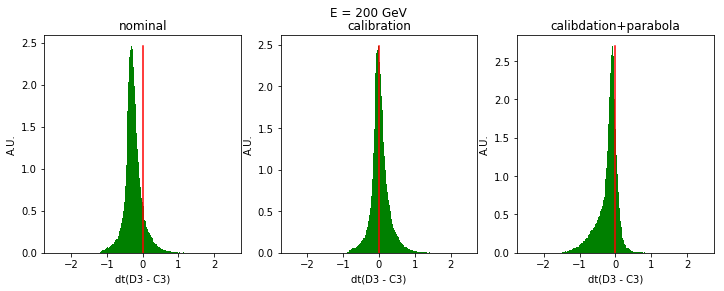

(250.0, 'dt_ecal_MCP_D3', 'results : mu = 1.153, s = 0.037')
(250.0, 'dt_ecal_MCP_D3_calib', 'results : mu = 1.153, s = 0.037')
(250.0, 'dt_ecal_MCP_D3_calib_subtracted', 'results : mu = 1.153, s = 0.037')


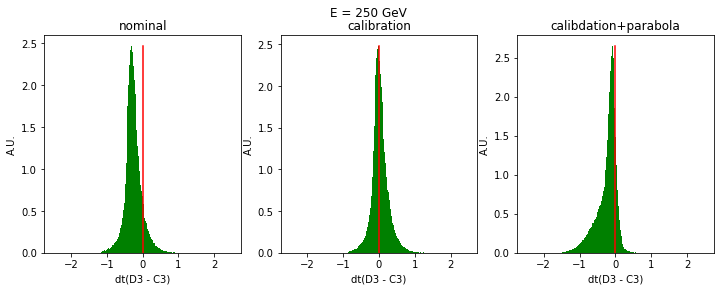

In [54]:
import matplotlib.mlab as mlab
from scipy.stats import norm


for n_energy,energy in enumerate(round_energies):
    df = dict_df_energy_seedC3[int(energy)]
    
    f, axarr = plt.subplots(1, 3)
    DefaultSize = f.get_size_inches()
    f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]) )
    f.suptitle('E = %d GeV'%energy)

    cr = 'D3'
    #what_list=('dt_ecal_MCP_%s,dt_ecal_MCP_%s_calib,dt_ecal_MCP_%s_calib_subtracted,dr_%s,par'%(cr,cr,cr,cr)).split(',')
    what_list=('dt_ecal_MCP_%s,dt_ecal_MCP_%s_calib,dt_ecal_MCP_%s_calib_subtracted'%(cr,cr,cr)).split(',')
    for num,what in enumerate(what_list):
        legend = ['nominal','calibration','calibdation+parabola']#,'dR','par']
        trange=[-2.5,2.5]
        if num!=4 : res = df['%s'%what]-df['dt_ecal_MCP_C3']
        if num==4 :  
            res = df[what_list[1]]-df[what_list[2]]
            range=[-0.5,0.5]
        if num==3 : n,bins,_ = axarr[num].hist(df['%s'%what],bins=200,density=1,color='g')
        else : n,bins,_ = axarr[num].hist(res,bins=200,range=trange,density=1,color='g')
        axarr[num].plot([0]*10,np.linspace(0,max(n),10),color='r')
        axarr[num].set_title(legend[num])
        axarr[num].set_xlabel('dt(%s - C3)'%cr)
       # axarr[num].set_ylim(0,8) 
        axarr[num].set_ylabel('A.U.')
        
        print(energy, what, 'results : mu = %.3f, s = %.3f'%(loc, scale))
    plt.show()

200.0 dt_ecal_MCP_C3 results :  2.2024970379092155 6.881921880097621 1.1915148043475012 0.08634294097127206


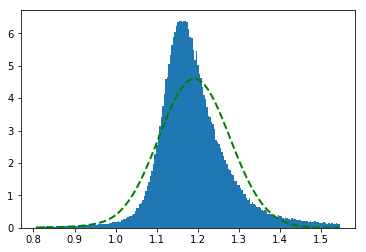

250.0 dt_ecal_MCP_C3 results :  2.2521542032544097 4.75346508842061 1.1878554096758447 0.09157933779729775


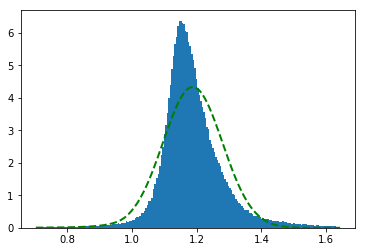

In [55]:
import matplotlib.mlab as mlab
from scipy.stats import norm

#what = 'fit_time_ecal_MCP_C3_subtracted'
what = 'dt_ecal_MCP_C3'
for num,energy in enumerate(round_energies[3:5]):
#for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)]
    #subdf = df.loc[(df['sum_time_crystals']>500) & (df['sum_time_crystals']<600) & (df['seed'] == df['C3'])]
    #beta, cb_m, loc, scale = crystalball.fit(subdf['sum_time_crystals'],loc=subdf['sum_time_crystals'].median(),scale=subdf['sum_time_crystals'].std())
    #n,bins,_ = plt.hist(df['fit_time_C3'],bins=50)
    #y = crystalball.pdf( bins, beta, cb_m, loc, scale)
    #l = plt.plot(bins, y, 'g--', linewidth=2)
    #plt.show()
    
    
   #subdf = df.loc[(np.abs(df['%s'%what])<0.3)]
    loc = subdf['%s'%what].median()
    std = subdf['%s'%what].std()
    subdf = df.loc[(np.abs(df['%s'%what]-loc)<5*std)]
    loc = subdf['%s'%what].median()
    std = subdf['%s'%what].std()
    subdf = df.loc[(np.abs(df['%s'%what]-loc)<5*std)]

    
    n,bins,_ = plt.hist(subdf['%s'%what],bins=200,density=1)
    beta, cb_m, loc, scale = crystalball.fit(subdf['%s'%what],loc=loc,scale=scale)
    y = crystalball.pdf( bins, beta, cb_m, loc, scale)
    #(mu, sigma) = norm.fit(subdf['fit_time_ecal_MCP_C3_subtracted'],loc=loc,scale=scale)
    #y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'g--', linewidth=2)
    print energy, what, 'results : ',beta, cb_m, loc, scale
    plt.show()

In [79]:
df = dict_df_energy[50] 
i=0
j=1
x_center = (j+1)*22-11-33
y_center = (i+1)*22-11-33
print x_center,y_center
crystal='C2'
subdf = df.loc[ (df['ecal_x_%s'%crystal]<(x_center+11)) & (df['ecal_x_%s'%crystal]>(x_center-11)) &(df['ecal_y_%s'%crystal]<(y_center+11)) & (df['ecal_y_%s'%crystal]>(y_center-11))   ] 



0 -22


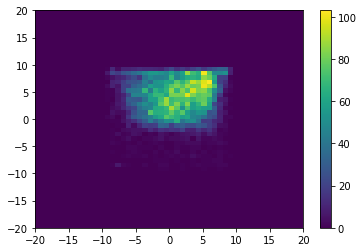

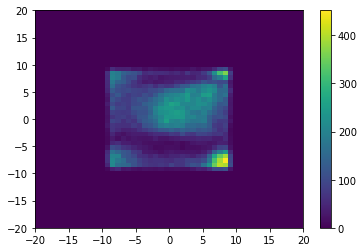

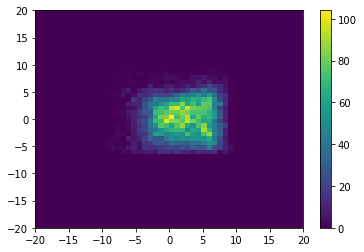

In [86]:
x_center=0
y_center=0
crystal='C4'
d3 = df.loc[(df['seed']==df['C4']) &(df['ecal_x_%s'%crystal]<(x_center+9)) & (df['ecal_x_%s'%crystal]>(x_center-9)) &(df['ecal_y_%s'%crystal]<(y_center+9)) & (df['ecal_y_%s'%crystal]>(y_center-9)) ]
h=plt.hist2d(d3['ecal_x_C4'],d3['ecal_y_C4'], range=[[-20,20],[-20,20]], bins=(50,50))
plt.colorbar()
plt.show()

crystal='C3'
d = df.loc[(df['seed']==df['C3']) &(df['ecal_x_%s'%crystal]<(x_center+9)) & (df['ecal_x_%s'%crystal]>(x_center-9)) &(df['ecal_y_%s'%crystal]<(y_center+9)) & (df['ecal_y_%s'%crystal]>(y_center-9)) ]
h=plt.hist2d(d['ecal_x_C3'],d['ecal_y_C3'], range=[[-20,20],[-20,20]], bins=(50,50))
plt.colorbar()
plt.show()

crystal='C2'
d2 = df.loc[(df['seed']==df['C2']) &(df['ecal_x_%s'%crystal]<(x_center+9)) & (df['ecal_x_%s'%crystal]>(x_center-9)) &(df['ecal_y_%s'%crystal]<(y_center+9)) & (df['ecal_y_%s'%crystal]>(y_center-6)) ]
h=plt.hist2d(d2['ecal_x_C2'],d2['ecal_y_C2'], range=[[-20,20],[-20,20]], bins=(50,50))
plt.colorbar()
plt.show()



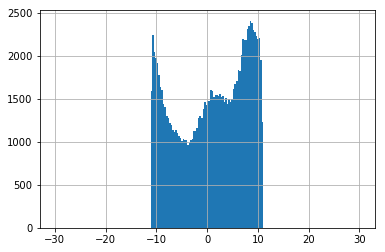

In [52]:
subdf['ecal_x_C2'].hist(bins=200,range=[-30,30])